# Домашнее задание 2. Преобразование данных

Цель этого задания -- преобразовать имеющиеся атрибуты пользователей в признаки так, чтобы полученная матрица признаков была пригодна для подачи в алгоритм кластеризации. Этап конструирования признаков -- самый важный и обычно самый долгий. К нему возвращаются много раз на протяжении решения задачи анализа данных.

Кроме библиотек, использованных в первом задании, нам понадобятся следующие библиотеки:
1. [scikit-learn](http://scikit-learn.org/stable/) -- библиотека, реализующая множество алгоритмов машинного обучения и сопутствующих алгоритмов

In [2]:
import pandas as pd
import numpy as np
import pylab as pl
import sklearn.preprocessing as sp
import csv
import re
import datetime

np.set_printoptions(linewidth=150, precision=3, suppress=True)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [8]:
ts_parser = lambda date_str: datetime.datetime.strptime(date_str, "%Y-%m") if pd.notnull(date_str) and date_str else None
df_users = pd.read_csv("hw1_out.csv", sep="\t", encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC, converters={"created_at": ts_parser})
# Remove rows with users not found
df_users = df_users[pd.notnull(df_users['name'])]
df_users["lat"].fillna(value=0, inplace=True)
df_users["lon"].fillna(value=0, inplace=True)

In [9]:
# Number of words in username
REGEX_WHITESPACE = re.compile("\s+")
df_users["name_words"] = df_users["name"].map(lambda n: len(REGEX_WHITESPACE.split(n)))
# Length of screen name in symbols
df_users["screen_name_length"] = df_users["screen_name"].map(lambda n: len(n))
# Length of description in words
df_users["description_length"] = df_users["description"].map(lambda d: len(d) if pd.notnull(d) else 0)
# Year when account was created
df_users["created_year"] = df_users["created_at"].map(lambda d: d.year)
# Country code
country_code_map = dict((c, i) for i, c in enumerate(df_users["country"].unique()))
df_users["country_code"] = df_users["country"].map(lambda c: country_code_map[c])
# Verification
df_users["verified"] = df_users["verified"].astype(int)

In [20]:
features = ["verified", "lat", "lon", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count", "name_words", "screen_name_length", "description_length", "created_year", "country_code"]
x = df_users[pd.notnull(df_users.cat)][features].values
y = df_users[pd.notnull(df_users.cat)]["cat"].values

Посмотрим, являются ли какие-либо из выбранных признаков сильно скоррелированными. Для этого посчитаем матрицу корреляций и выберем те пары признаков, абсолютное значения коэффициента корреляции между которыми больше 0.2.

In [21]:
for (i, j), corr in np.ndenumerate(np.corrcoef(x, rowvar=0)):
    if i < j and np.abs(corr) > 0.25:
        print "Correlated features: %s + %s -> %.2f" % (features[i], features[j], corr)

Correlated features: lat + lon -> -0.77
Correlated features: lon + country_code -> 0.34
Correlated features: followers_count + friends_count -> 0.80
Correlated features: followers_count + listed_count -> 0.93
Correlated features: friends_count + listed_count -> 0.71
Correlated features: statuses_count + favourites_count -> 0.28


Выделилось 3 группы признаков:
1. Основанные на географии:  "lat", "lon", "country_code"
2. Основанные на социальной активности:  "verified", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count", "created_year"
3. Остальные:  "name_words", "screen_name_length", "description_length"

Построим взаимные распределения пар признаков в каждой из групп, а также гистограмму значений каждого из признаков с учетом целевой переменной.

In [25]:
def plot_two_features_scatter(x_i, x_j, y):
    colors = map(lambda y_i: ["g", "r"][int(y_i)], y)
    pl.scatter(x_j, x_i, color=colors, alpha=0.6, s=2)    

    
def plot_feature_histogram(x_i, y):
    x_i_nn = x_i[pd.notnull(x_i)]
    y_nn = y[pd.notnull(x_i)]
    # Compute positive and negative histograms
    n_uniqe = np.unique(x_i_nn).shape[0]
    n_bins = int(np.log2(n_uniqe)) + 1
    bins = np.linspace(np.min(x_i_nn), np.max(x_i_nn), n_bins + 1)
    histogram_pos = np.histogram(x_i_nn[y_nn == 1], bins)
    histogram_neg = np.histogram(x_i_nn[y_nn == 0], bins)
    # Plot stacked barplots
    width = 0.3 * (bins[1] - bins[0])
    pl.bar(bins[:-1], histogram_pos[0], width, color='r', alpha=0.6, linewidth=0)
    pl.bar(bins[:-1] + width, histogram_neg[0], width, color='g', alpha=0.6, linewidth=0)


def plot_dataset(x, y, features):
    pl.figure(figsize=(15, 15))

    for i, feature_i in enumerate(features):
        for j, feature_j in enumerate(features):
            axis = pl.subplot(len(features), len(features), len(features) * i + j + 1)
            pl.tick_params(labelbottom=False, labelleft=False)
            axis.xaxis.set_label_position('top')
            if i == 0:
                pl.xlabel(feature_j)
            if j == 0:
                pl.ylabel(feature_i)
            # Do actual plotting
            if i != j:
                plot_two_features_scatter(x[:, i], x[:, j], y)            
            else:
                plot_feature_histogram(x[:, i], y)
    
    pl.show()

Построим попарные распределения географических признаков ([подсказка](http://anokhin.github.io/img/hw2_geo.png)).

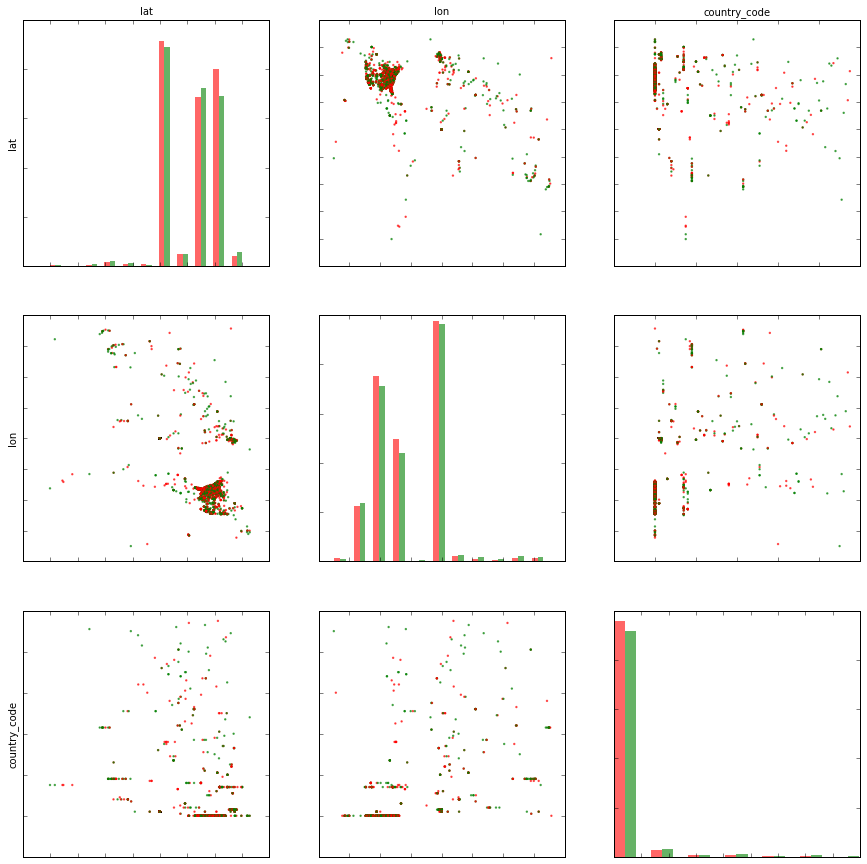

In [26]:
geo_features = ["lat", "lon", "country_code"]
geo_feature_ind = [i for i, f in enumerate(features) if f in geo_features]
plot_dataset(x[:, geo_feature_ind], y, geo_features)

Четко видны очертания карты и то, что большинство пользователей происходят из небольшого набора стран. Если принять во внимание конечную цель -- кластеризацию пользователей -- логично предположить, что использование географических признаков для описания пользователя может оказаться не очень полезным. Причина в том, что эти признаки четко пространственно разделены (как минимум, океанами и морями). Поэтому мы рискуем вместо "интересной" кластеризации получить просто кластеры, которые будут представлять разные страны. В дальнейшем мы исключим географические признаки из рассмотрения при кластеризации пользователей.

Далее построим попарные распределения социальных признаков ([подсказка](http://anokhin.github.io/img/hw2_social1.png)).

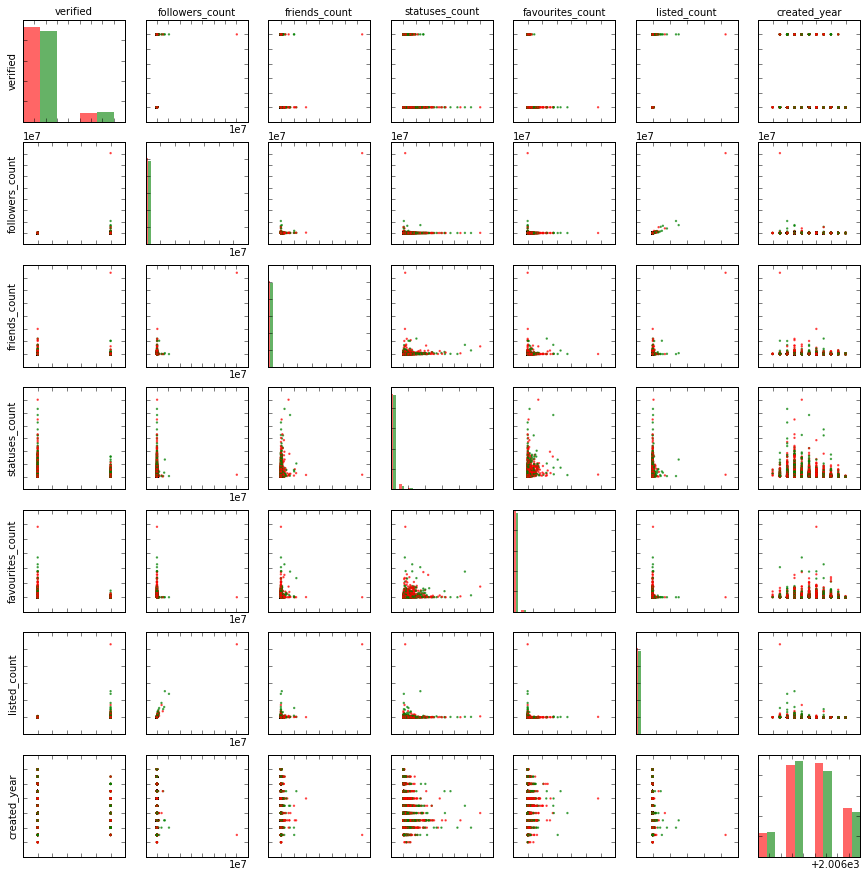

In [27]:
social_features = ["verified", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count", "created_year"]
social_feature_ind = [i for i, f in enumerate(features) if f in social_features]
plot_dataset(x[:, social_feature_ind], y, social_features)

Из графиков видно, что признаки "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count" сильно смещены в сторону небольших значений. В таком случае удобно сделать логарифмическое преобразрвание этих признаков, то есть применить к их значениям $x_{ij}$ функцию $\log(1 + x_{ij})$. Сделаем это и построим новые распределения ([подсказка](http://anokhin.github.io/img/hw2_social2.png)).

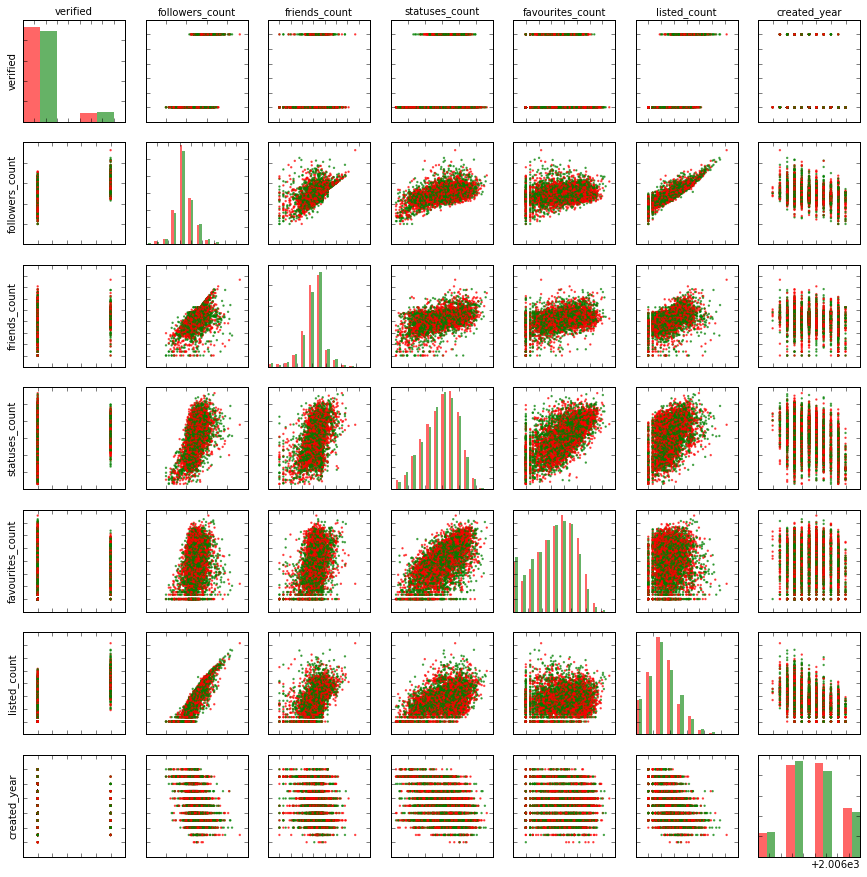

In [28]:
transformed_features = ["followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"]
for i, f in enumerate(features):
    if f in transformed_features:
        x[:, i] = np.log1p(x[:, i])

# Re-plot features
plot_dataset(x[:, social_feature_ind], y, social_features)

Сразу бросается в глаза, что признак "verified" сильно смещен -- верифицированных пользователей очень мало. Более того, все верифицированные пользователи имеют много фолловеров, поэтому часть информации о верификации дублируется в признаке "followers_count". По этой причине в дальнейшем не будем рассмтаривать признак "verified".

После того как мы с помощью логарифмического преобразования избавились от сильной скошенности признаков, можно наблюдать некоторые интересные зависимости. Например, пользователи, имеющие много фолловеров, обязательно имеют много статусов. Следовательно, чтобы стать популярным, обязательно нужно много писать. Анализ других зависимостей остается как упражнение.

Наконец построим попарные распределения остальных признаков ([подсказка](http://anokhin.github.io/img/hw2_other.png)).

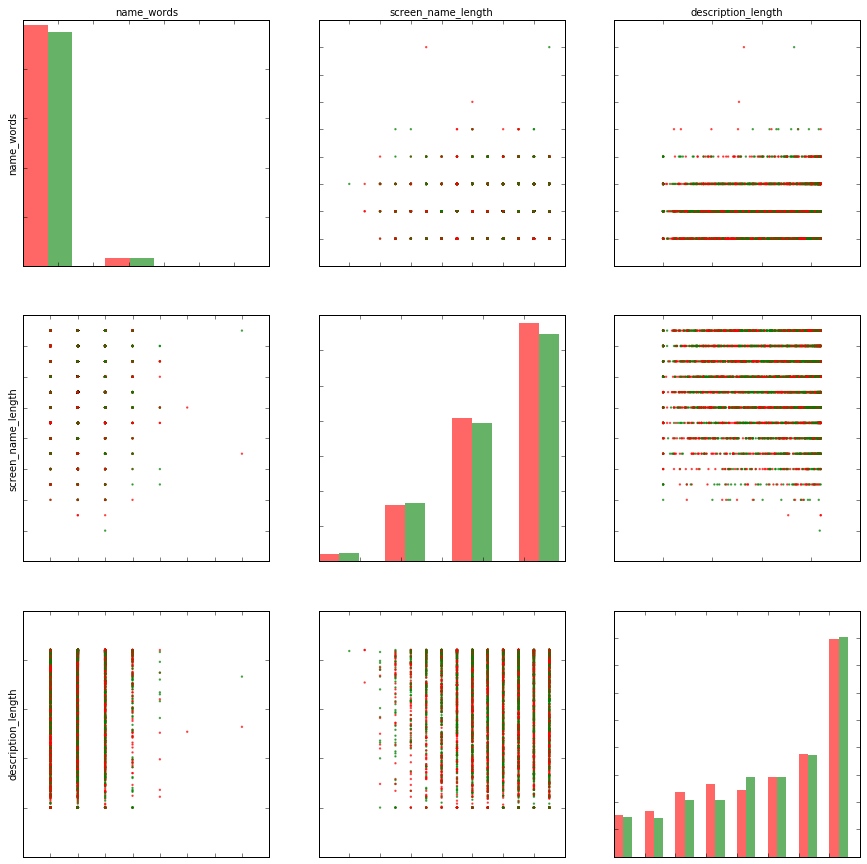

In [29]:
other_features = ["name_words", "screen_name_length", "description_length"]
other_feature_ind = [i for i, f in enumerate(features) if f in other_features]
plot_dataset(x[:, other_feature_ind], y, other_features)

Итак после первичной обработки данных мы имеем 9 числовых признаков, каждый з которых распределен в некотором своем интервале. Для того, чтобы ни один признак не получил перевеса при кластеризации, нормализуем данные так, что каждый признак распределен на отрезке $[0, 1]$. 

In [34]:
selected_features = ["followers_count", "friends_count", "statuses_count", "favourites_count", 
                     "listed_count", "created_year", "name_words", "screen_name_length", "description_length"]

x_1 = df_users[selected_features].values
y = df_users["cat"].values

# x_1 = x[:, selected_features_ind]
# Replace nan with 0-s
# Is there a smarter way?
x_1[np.isnan(x_1)] = 0
x_min = x_1.min(axis=0)
x_max = x_1.max(axis=0)
x_new = (x_1 - x_min) / (x_max - x_min)

Упакуем полученную матрицу в pandas DataFrame и сохраним в файл "hw2_out.csv". В следующем задании мы будем кластеризовать пользователей на оновании этих данных.

In [35]:
df_out = pd.DataFrame(data=x_new, index=df_users["uid"], columns=selected_features)
df_out.to_csv("hw2_out.csv", sep="\t")